In [ ]:
import os
import math
import torch
from datasets import load_dataset
from transformers import GPT2LMHeadModel, AutoTokenizer
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "gpt2"
LLM_MODEL_PATH = "/ai/shenwei/workspace/Models/huggingface/gpt2"
LOCAL_DATA_PATH = "/ai/LLM_DATA/huggingface/wikitext"
MODEL_MAX_POS = 1024  # ⚠️ GPT-2 硬限制
MAX_POS = 1024
STRIDE = 256
MAX_TOKENS = 100_000  # 控制规模

def load_tokens():
    if os.path.exists(LLM_MODEL_PATH):
        tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_PATH)
    else:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token

    if os.path.exists(LOCAL_DATA_PATH):
        ds = load_dataset(f"{LOCAL_DATA_PATH}/wikitext-103-v1", split="validation")
    else:
        ds = load_dataset("wikitext", "wikitext-103-v1", split="validation")
    text = "\n\n".join(ds["text"])
    tokens = tokenizer(text, return_tensors="pt")["input_ids"][0]
    return tokens[:MAX_TOKENS], tokenizer

@torch.no_grad()
def evaluate_base(model, tokens, max_pos=MAX_POS, stride=STRIDE):
    model.eval()
    nlls = []
    total = 0

    for i in tqdm(range(0, len(tokens) - 1, stride), desc="GPT-2"):
        if max_pos > MODEL_MAX_POS:
            max_pos = MODEL_MAX_POS
            stride = max_pos // 4
        begin = max(i + stride - max_pos, 0)
        end = min(i + stride, len(tokens))
        trg_len = end - i

        ids = tokens[begin:end].unsqueeze(0).to(DEVICE)
        labels = ids.clone()
        labels[:, :-trg_len] = -100

        out = model(ids, labels=labels)
        loss = out.loss.item()
        nlls.append(loss * trg_len)
        total += trg_len

        if end == len(tokens):
            break

    ppl = math.exp(sum(nlls) / total)
    return ppl

def main():
    tokens, tokenizer = load_tokens()
    tokens = tokens.to(DEVICE)

    if os.path.exists(LLM_MODEL_PATH):
        model = GPT2LMHeadModel.from_pretrained(LLM_MODEL_PATH).to(DEVICE)
    else:
        model = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)

    ppl = evaluate_base(model, tokens)
    print(f"GPT-2 baseline PPL: {ppl:.2f}")


# main()


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

MEMORY_SIZE = 256
MEMORY_ALPHA = 0.1
WRITE_FREQ = 4
WRITE_TOKENS = 128

class TitansMemory(nn.Module):
    def __init__(self, d_model, size):
        super().__init__()
        self.register_buffer("mem", torch.zeros(size, d_model))
        self.register_buffer("strength", torch.zeros(size))
        self.decay, self.lr = 0.98, 0.05

    @torch.no_grad()
    def reset(self):
        self.mem.zero_()
        self.strength.zero_()

    @torch.no_grad()
    def write(self, h, surprise):
        s = torch.nan_to_num(surprise.mean(0), 0.0)
        k = min(len(s), self.mem.size(0) // 8)
        if k == 0:
            return
        _, idx = torch.topk(s, k)
        content = F.normalize(h.mean(0)[idx].detach(), dim=-1)

        self.mem.mul_(self.decay)
        self.strength.mul_(self.decay)
        self.mem[:k] += self.lr * content
        self.strength[:k] += s[idx]

    def read(self, h):
        q = F.normalize(h, dim=-1)
        m = F.normalize(self.mem, dim=-1)
        attn = torch.einsum("btd,md->btm", q, m)
        attn = attn * self.strength
        attn = torch.softmax(attn, dim=-1)
        return torch.einsum("btm,md->btd", attn, self.mem)

class TitansGPT2(nn.Module):
    def __init__(self):
        super().__init__()
        if os.path.exists(LLM_MODEL_PATH):
            self.gpt2 = GPT2LMHeadModel.from_pretrained(LLM_MODEL_PATH)
        else:
            self.gpt2 = GPT2LMHeadModel.from_pretrained(MODEL_NAME)
        d = self.gpt2.config.n_embd
        self.memory = TitansMemory(d, MEMORY_SIZE)
        self.mem_ln = nn.LayerNorm(d)
        self.mem_gate = nn.Linear(d,1)

    def forward(self, ids, labels, step):
        # embed
        embeds = self.gpt2.transformer.wte(ids)

        # predict for surprise and memory write
        with torch.no_grad():
            logits_pred = self.gpt2(inputs_embeds=embeds).logits
            pred_ids = logits_pred.argmax(-1)
            pred_embeds = self.gpt2.transformer.wte(pred_ids)

            surprise = torch.norm(
                embeds[:,-WRITE_TOKENS:] - pred_embeds[:,-WRITE_TOKENS:], dim=-1
            )

            if step % WRITE_FREQ == 0:
                self.memory.write(embeds[:,-WRITE_TOKENS:], surprise)

            mem = self.memory.read(embeds[:,-WRITE_TOKENS:])

        mem = self.mem_ln(mem)
        gate = torch.sigmoid(self.mem_gate(embeds[:,-WRITE_TOKENS:]))

        mod_embeds = embeds.clone()
        mod_embeds[:,-WRITE_TOKENS:] += MEMORY_ALPHA * gate * mem

        out = self.gpt2(inputs_embeds=mod_embeds, labels=labels)
        return out.loss

@torch.no_grad()
def evaluate_titans(model, tokens, max_pos=MAX_POS, stride=STRIDE):
    model.eval()
    model.memory.reset()
    nlls, total = [], 0

    for step, i in enumerate(range(0, len(tokens), stride)):
        begin = max(i + stride - max_pos, 0)
        end = min(i + stride, len(tokens))
        trg_len = end - i

        ids = tokens[begin:end].unsqueeze(0).to(DEVICE)
        labels = ids.clone()
        labels[:,:-trg_len] = -100

        loss = model(ids, labels, step).item()
        nlls.append(loss * trg_len)
        total += trg_len

        if end == len(tokens):
            break

    ppl = math.exp(sum(nlls)/total)
    return ppl

def main():
    tokens, _ = load_tokens()
    tokens = tokens.to(DEVICE)

    model = TitansGPT2().to(DEVICE)

    ppl = evaluate_titans(model, tokens)
    print(f"Titans PPL: {ppl:.2f}")


# main()

In [ ]:
class TitansMemory(nn.Module):
    def __init__(self, d_model, size):
        super().__init__()
        self.register_buffer("mem", torch.zeros(size, d_model))
        self.register_buffer("strength", torch.zeros(size))
        self.decay = 0.98
        self.lr = 0.05
        self.ptr = 0   # circular buffer

    @torch.no_grad()
    def reset(self):
        self.mem.zero_()
        self.strength.zero_()
        self.ptr = 0

    @torch.no_grad()
    def write(self, h, surprise):
        """
        h: [B, T, D]  —— 即将被移出 attention window 的 token
        """
        s = torch.nan_to_num(surprise.mean(0), 0.0)
        if s.numel() == 0:
            return

        k = min(len(s), self.mem.size(0) // 8)
        _, idx = torch.topk(s, k)

        content = F.normalize(h.mean(0)[idx], dim=-1)

        for i in range(k):
            self.mem[self.ptr] = content[i]
            self.strength[self.ptr] = s[idx[i]]
            self.ptr = (self.ptr + 1) % self.mem.size(0)
    
    def read(self, q):
        if self.strength.sum() == 0:
            return torch.zeros_like(q)

        q = F.normalize(q, dim=-1)
        m = F.normalize(self.mem, dim=-1)

        attn = torch.einsum("btd,md->btm", q, m)
        attn = attn * self.strength
        attn = torch.softmax(attn, dim=-1)

        return torch.einsum("btm,md->btd", attn, self.mem)

class TitansGPT2(nn.Module):
    def __init__(self):
        super().__init__()
        if os.path.exists(LLM_MODEL_PATH):
            self.gpt2 = GPT2LMHeadModel.from_pretrained(LLM_MODEL_PATH)
        else:
            self.gpt2 = GPT2LMHeadModel.from_pretrained(MODEL_NAME)
        d = self.gpt2.config.n_embd

        self.memory = TitansMemory(d, MEMORY_SIZE)
        self.mem_ln = nn.LayerNorm(d)
        self.mem_gate = nn.Linear(d, 1)

    def forward(self, ids, labels, step):
        embeds = self.gpt2.transformer.wte(ids)

        # 写 memory：只在 window 滑动时
        if step > 0 and step % WRITE_FREQ == 0:
            with torch.no_grad():
                logits = self.gpt2(inputs_embeds=embeds).logits
                pred = logits.argmax(-1)
                pred_emb = self.gpt2.transformer.wte(pred)

                surprise = torch.norm(
                    embeds[:, :WRITE_TOKENS] - pred_emb[:, :WRITE_TOKENS],
                    dim=-1
                )

                self.memory.write(
                    embeds[:, :WRITE_TOKENS],
                    surprise
                )

        # 读 memory（补充历史）
        mem = self.memory.read(embeds)
        mem = self.mem_ln(mem)
        gate = torch.sigmoid(self.mem_gate(embeds))

        mod_embeds = embeds + MEMORY_ALPHA * gate * mem

        out = self.gpt2(inputs_embeds=mod_embeds, labels=labels)
        return out.loss

@torch.no_grad()
def evaluate_titans(model, tokens, max_pos=1024, stride=256):
    model.eval()
    model.memory.reset()

    nlls, total = [], 0

    for step, i in enumerate(range(0, len(tokens) - 1, stride)):
        begin = max(0, i + stride - max_pos)
        end = min(i + stride, len(tokens) - 1)

        ids = tokens[begin:end].unsqueeze(0)
        labels = tokens[begin+1:end+1].unsqueeze(0)

        loss = model(ids, labels, step)
        nlls.append(loss.item() * (end - i))
        total += (end - i)

        if end == len(tokens) - 1:
            break

    return math.exp(sum(nlls) / total)



In [ ]:
import matplotlib.pyplot as plt

# 画图 
def picture():
    windows = [512, 1024, 2048, 4096]
    baseline_ppls = []
    titans_ppls = []
    if os.path.exists(LLM_MODEL_PATH):
        gpt2_model = GPT2LMHeadModel.from_pretrained(LLM_MODEL_PATH).to(DEVICE)
    else:
        gpt2_model = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)

    titans_model = TitansGPT2().to(DEVICE)

    for w in windows:
        stride = w // 4
        max_pos = w

        print(f"Context Window: {w}, Stride: {stride}")

        tokens, _ = load_tokens()
        tokens = tokens.to(DEVICE)
        gpt2_ppl = evaluate_base(gpt2_model, tokens, max_pos=max_pos, stride=stride)
        baseline_ppls.append(gpt2_ppl)

        t_ppl = evaluate_titans(titans_model, tokens, max_pos=max_pos, stride=stride)
        titans_ppls.append(t_ppl)

    plt.plot(windows, baseline_ppls, label="GPT-2")
    plt.plot(windows, titans_ppls, label="Titans")
    plt.xlabel("Context Window")
    plt.ylabel("PPL")
    plt.legend()
    plt.show()

    for w in windows:
        print(f"Context Window: {w}")
        print("Titans PPL:", titans_ppls[windows.index(w)])
        print("GPT-2 PPL:", baseline_ppls[windows.index(w)])
        print()

picture()


In [1]:
import math
import os
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from datasets import load_dataset
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_NAME = "gpt2"
MODEL_MAX_POS = 1024      # ⚠️ GPT-2 硬限制
STRIDE = 256              # sliding step

LLM_MODEL_PATH = "/ai/shenwei/workspace/Models/huggingface/gpt2"
LOCAL_DATA_PATH = "/ai/LLM_DATA/huggingface/wikitext"

/ai/shenwei/workspace/codes/ModelServe/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_wikitext_tokens():
    if os.path.exists(LLM_MODEL_PATH):
        tokenizer = GPT2TokenizerFast.from_pretrained(LLM_MODEL_PATH)
    else:
        tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token

    if os.path.exists(LOCAL_DATA_PATH):
        dataset = load_dataset(f"{LOCAL_DATA_PATH}/wikitext-2-raw-v1", split="test")
    else:
        dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
    text = "\n\n".join(dataset["text"])

    tokens = tokenizer(
        text,
        return_tensors="pt",
        truncation=False
    ).input_ids[0]

    return tokens.to(DEVICE)


In [3]:
@torch.no_grad()
def eval_gpt2_sliding(model, tokens):
    model.eval()
    losses = []

    for start in tqdm(range(0, len(tokens) - 1, STRIDE), desc="GPT-2"):
        end = min(start + MODEL_MAX_POS, len(tokens) - 1)
        input_ids = tokens[start:end].unsqueeze(0)
        labels = tokens[start + 1:end + 1].unsqueeze(0)

        outputs = model(input_ids, labels=labels)
        losses.append(outputs.loss.item())

    return math.exp(sum(losses) / len(losses))


In [4]:
class TitansMemory:
    def __init__(self, hidden_size, max_steps):
        self.hidden_size = hidden_size
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.bank = []

    def write(self, hidden):
        # hidden: [1, T, H] → [H]
        summary = hidden.mean(dim=1).squeeze(0).detach()
        self.bank.append(summary)
        if len(self.bank) > self.max_steps:
            self.bank.pop(0)

    def read(self):
        if len(self.bank) == 0:
            return None
        return torch.stack(self.bank, dim=0).mean(dim=0)


In [5]:
class TitansGPT2(nn.Module):
    def __init__(self, memory_steps):
        super().__init__()
        if os.path.exists(LLM_MODEL_PATH):
            self.model = GPT2LMHeadModel.from_pretrained(LLM_MODEL_PATH).to(DEVICE)
        else:
            self.model = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)
        self.hidden = self.model.config.n_embd
        self.memory = TitansMemory(self.hidden, memory_steps)

    @torch.no_grad()
    def forward(self, input_ids, labels):
        out = self.model(
            input_ids=input_ids,
            output_hidden_states=True,
            labels=labels
        )

        last_hidden = out.hidden_states[-1]
        self.memory.write(last_hidden)

        mem = self.memory.read()
        if mem is not None:
            out.logits[:, -1, :] += torch.matmul(
                self.model.lm_head.weight,
                mem
            )

        return out


In [6]:
@torch.no_grad()
def eval_titans(tokens, effective_context):
    memory_steps = max(1, (effective_context - MODEL_MAX_POS) // STRIDE)
    model = TitansGPT2(memory_steps)
    model.eval()
    model.memory.reset()

    losses = []

    for start in tqdm(range(0, len(tokens) - 1, STRIDE), desc=f"Titans@{effective_context}"):
        end = min(start + MODEL_MAX_POS, len(tokens) - 1)

        input_ids = tokens[start:end].unsqueeze(0)
        labels = tokens[start + 1:end + 1].unsqueeze(0)

        out = model(input_ids, labels)
        losses.append(out.loss.item())

    return math.exp(sum(losses) / len(losses))


In [7]:

tokens = load_wikitext_tokens()

if os.path.exists(LLM_MODEL_PATH):
    gpt2 = GPT2LMHeadModel.from_pretrained(LLM_MODEL_PATH).to(DEVICE)
else:
    gpt2 = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)
gpt2.eval()

print("\nEvaluating GPT-2 baseline (effective ≤1024)")
gpt2_ppl = eval_gpt2_sliding(gpt2, tokens)

for ctx in [2048, 4096]:
    print(f"\nEvaluating Titans (effective context = {ctx})")
    titans_ppl = eval_titans(tokens, ctx)

    print("==============================")
    print(f"GPT-2   PPL : {gpt2_ppl:.2f}")
    print(f"Titans PPL : {titans_ppl:.2f}")
    print("==============================")


Token indices sequence length is longer than the specified maximum sequence length for this model (287644 > 1024). Running this sequence through the model will result in indexing errors



Evaluating GPT-2 baseline (effective ≤1024)


GPT-2: 100%|██████████| 1124/1124 [00:23<00:00, 48.76it/s]



Evaluating Titans (effective context = 2048)


Titans@2048: 100%|██████████| 1124/1124 [00:23<00:00, 48.57it/s]


GPT-2   PPL : 8772.58
Titans PPL : 8772.58

Evaluating Titans (effective context = 4096)


Titans@4096: 100%|██████████| 1124/1124 [00:23<00:00, 48.23it/s]

GPT-2   PPL : 8772.58
Titans PPL : 8772.58


| 项目               | 设置              |
| ---------------- | --------------- |
| Base model       | GPT-2           |
| Attention window | 1024            |
| Stride           | 256             |
| Dataset          | WikiText-2 test |
| Metric           | PPL             |
| Eval             | sliding window  |
| Memory           | test-time only  |
| Seeds            | 固定              |


In [15]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LLM_MODEL_PATH = "/ai/shenwei/workspace/Models/huggingface/gpt2"
LOCAL_DATA_PATH = "/ai/LLM_DATA/huggingface/wikitext"
MODEL_NAME = "gpt2"
MAX_POS = 1024
STRIDE = 256
OVERLAP = MAX_POS - STRIDE

# ---- Titans memory hyperparams ----
WRITE_TOKENS = 128
MEMORY_SIZE = 24        # 24 × 128 = 3072 → effective ≈ 4096
MEMORY_ALPHA = 0.1

In [2]:
def load_tokens():
    if os.path.exists(LLM_MODEL_PATH):
        tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_PATH)
    else:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token

    if os.path.exists(LOCAL_DATA_PATH):
        ds = load_dataset(f"{LOCAL_DATA_PATH}/wikitext-103-v1", split="validation")
    else:
        ds = load_dataset("wikitext", "wikitext-103-v1", split="validation")
    text = "\n\n".join(ds["text"])
    tokens = tokenizer(text, return_tensors="pt")["input_ids"][0]
    return tokens.to(DEVICE)  # [:MAX_TOKENS], tokenizer

In [16]:
class TitansMemory(nn.Module):
    def __init__(self, d_model, size):
        super().__init__()
        self.size = size
        self.register_buffer("mem", torch.zeros(size, d_model))
        self.register_buffer("strength", torch.zeros(size))
        self.ptr = 0

    @torch.no_grad()
    def reset(self):
        self.mem.zero_()
        self.strength.zero_()
        self.ptr = 0

    @torch.no_grad()
    def old_write(self, h, surprise=None):
        """
        h: [B, T, D]   (T = WRITE_TOKENS)
        surprise: [B, T]
        """
        if surprise is None:
            content = F.normalize(h.mean(0), dim=-1)

            for i in range(min(len(content), self.size)):
                self.mem[self.ptr] = content[i]
                self.strength[self.ptr] = 1.0
                self.ptr = (self.ptr + 1) % self.size
        else:
            s = torch.nan_to_num(surprise.mean(0), 0.0)
            if s.numel() == 0:
                return

            k = min(len(s), self.size // 4)
            _, idx = torch.topk(s, k)

            content = F.normalize(h.mean(0)[idx], dim=-1)

            for i in range(k):
                self.mem[self.ptr] = content[i]
                self.strength[self.ptr] = s[idx[i]]
                self.ptr = (self.ptr + 1) % self.size
    
    @torch.no_grad()
    def write(self, h, surprise=None):
        """
        h: [B, T, D]   tokens guaranteed to be OUTSIDE future windows
        """
        B, T, D = h.shape
        if T == 0:
            return

        max_k = min(self.size // 4, T)
        if max_k <= 0:
            return

        if surprise is not None:
            s = torch.nan_to_num(surprise.mean(0), 0.0)
            k = min(max_k, s.numel())
            _, idx = torch.topk(s, k)
            idx = idx.clamp(0, T - 1)
        else:
            k = max_k
            idx = torch.arange(k, device=h.device)

        content = F.normalize(h.mean(0)[idx], dim=-1)

        for i in range(k):
            self.mem[self.ptr].copy_(content[i])
            self.strength[self.ptr] = 1.0
            self.ptr = (self.ptr + 1) % self.size

    def read(self, q):
        if self.strength.sum() == 0:
            return torch.zeros_like(q)

        q = F.normalize(q, dim=-1)
        m = F.normalize(self.mem, dim=-1)

        attn = torch.einsum("btd,md->btm", q, m)
        attn = attn * self.strength
        attn = torch.softmax(attn, dim=-1)

        return torch.einsum("btm,md->btd", attn, self.mem)


In [17]:
class TitansGPT2(nn.Module):
    def __init__(self, memory_size=MEMORY_SIZE, use_surprise=True, use_gate=True):
        super().__init__()
        if os.path.exists(LLM_MODEL_PATH):
            self.gpt2 = GPT2LMHeadModel.from_pretrained(LLM_MODEL_PATH).to(DEVICE)
        else:
            self.gpt2 = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)
        d = self.gpt2.config.n_embd

        self.memory = TitansMemory(d, memory_size)
        self.mem_ln = nn.LayerNorm(d)
        self.mem_gate = nn.Linear(d, 1)

        # 
        self.use_surprise = use_surprise
        self.use_gate = use_gate

    def old_forward(self, ids, labels, step):
        embeds = self.gpt2.transformer.wte(ids)

        # ---- write memory: tokens that are sliding out ----
        if step > 0:
            with torch.no_grad():
                h_old = embeds[:, :WRITE_TOKENS]

                logits = self.gpt2(inputs_embeds=embeds).logits
                pred = logits.argmax(-1)
                pred_emb = self.gpt2.transformer.wte(pred)
                
                if self.use_surprise:
                    surprise = torch.norm(
                        h_old - pred_emb[:, :WRITE_TOKENS],
                        dim=-1
                    )

                    self.memory.write(h_old, surprise)
                else:
                    self.memory.write(h_old)

        # ---- read memory ----
        mem = self.memory.read(embeds)
        mem = self.mem_ln(mem)
        gate = torch.sigmoid(self.mem_gate(embeds))

        if self.use_gate:
            mod_embeds = embeds + MEMORY_ALPHA * gate * mem
        else:
            mod_embeds = embeds + MEMORY_ALPHA * mem

        out = self.gpt2(inputs_embeds=mod_embeds, labels=labels)
        return out.loss
    
    def forward(self, ids, labels, prev_embeds=None):
        embeds = self.gpt2.transformer.wte(ids)

        # ---- write ONLY non-overlapping tokens ----
        if prev_embeds is not None:
            with torch.no_grad():
                write_region = prev_embeds[:, :OVERLAP]

                if self.use_surprise:
                    logits = self.gpt2(inputs_embeds=write_region).logits
                    pred = logits.argmax(-1)
                    pred_emb = self.gpt2.transformer.wte(pred)
                    surprise = torch.norm(write_region - pred_emb, dim=-1)
                else:
                    surprise = None

                tail = write_region[:, -WRITE_TOKENS:]
                self.memory.write(tail, surprise)

        # ---- read memory ----
        mem = self.mem_ln(self.memory.read(embeds))

        if self.use_gate:
            gate = torch.sigmoid(self.mem_gate(embeds))
            embeds = embeds + MEMORY_ALPHA * gate * mem
        else:
            embeds = embeds + MEMORY_ALPHA * mem

        out = self.gpt2(inputs_embeds=embeds, labels=labels)
        return out.loss, embeds.detach()


In [18]:
@torch.no_grad()
def evaluate_titans(model, tokens):
    model.eval()
    model.memory.reset()

    nlls, total = [], 0
    prev_embeds = None

    for i in tqdm(range(0, len(tokens) - 1, STRIDE)):
        begin = max(0, i + STRIDE - MAX_POS)
        end = min(i + STRIDE, len(tokens) - 1)

        ids = tokens[begin:end].unsqueeze(0).to(DEVICE)
        labels = tokens[begin+1:end+1].unsqueeze(0).to(DEVICE)

        loss, curr_embeds = model(ids, labels, prev_embeds)

        nlls.append(loss.item() * (end - i))
        total += (end - i)

        prev_embeds = curr_embeds

        if end == len(tokens) - 1:
            break

    return math.exp(sum(nlls) / total)


In [6]:
@torch.no_grad()
def evaluate_gpt2(tokens):
    if os.path.exists(LLM_MODEL_PATH):
        model = GPT2LMHeadModel.from_pretrained(LLM_MODEL_PATH).to(DEVICE)
    else:
        model = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)
    model.eval()

    nlls, total = [], 0

    for i in tqdm(range(0, len(tokens) - 1, STRIDE), desc="GPT-2"):
        begin = max(0, i + STRIDE - MAX_POS)
        end = min(i + STRIDE, len(tokens) - 1)

        ids = tokens[begin:end].unsqueeze(0)
        labels = tokens[begin+1:end+1].unsqueeze(0)

        loss = model(ids, labels=labels).loss
        nlls.append(loss.item() * (end - i))
        total += (end - i)

        if end == len(tokens) - 1:
            break

    return math.exp(sum(nlls) / total)


In [10]:
def main():
    tokens = load_tokens()

    print("\nEvaluating GPT-2 baseline")
    gpt2_ppl = evaluate_gpt2(tokens)

    print("\nEvaluating Titans (effective context > 1024)")
    titans = TitansGPT2().to(DEVICE)
    titans_ppl = evaluate_titans(titans, tokens)

    print("\n==============================")
    print(f"GPT-2   PPL : {gpt2_ppl:.2f}")
    print(f"Titans PPL : {titans_ppl:.2f}")
    print("==============================")

main()


Token indices sequence length is longer than the specified maximum sequence length for this model (250896 > 1024). Running this sequence through the model will result in indexing errors



Evaluating GPT-2 baseline


GPT-2: 100%|█████████▉| 980/981 [00:20<00:00, 48.56it/s]



Evaluating Titans (effective context > 1024)


Titans: 100%|█████████▉| 980/981 [00:41<00:00, 23.82it/s]


GPT-2   PPL : 7876.41
Titans PPL : 5367.92


In [7]:
def sweep_memory_size(tokens):
    results = {}

    for m in [4, 8, 16, 24]:
        print(f"\nEvaluating Titans MEMORY_SIZE={m}")
        model = TitansGPT2(memory_size=m).to(DEVICE)

        ppl = evaluate_titans(model, tokens)
        results[m] = ppl

        print(f"MEMORY_SIZE={m} → PPL={ppl:.2f}")

    return results


**绘图**  
**结论**：Increasing memory capacity consistently reduces perplexity, confirming that Titans effectively exploits test-time memory to extend context beyond the transformer window.

In [8]:
import matplotlib.pyplot as plt

def plot_memory_sweep(results):
    xs = [k * WRITE_TOKENS + 1024 for k in results.keys()]
    ys = list(results.values())

    plt.figure(figsize=(6,4))
    plt.plot(xs, ys, marker="o")
    plt.xlabel("Effective Context Length")
    plt.ylabel("Perplexity (↓)")
    plt.title("Titans: Memory Size vs Perplexity")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("memory_sweep_ppl.png")


Token indices sequence length is longer than the specified maximum sequence length for this model (250896 > 1024). Running this sequence through the model will result in indexing errors



Evaluating Titans MEMORY_SIZE=4


Titans: 100%|█████████▉| 980/981 [00:40<00:00, 24.09it/s]


MEMORY_SIZE=4 → PPL=5474.50

Evaluating Titans MEMORY_SIZE=8


Titans: 100%|█████████▉| 980/981 [00:40<00:00, 24.31it/s]


MEMORY_SIZE=8 → PPL=5284.78

Evaluating Titans MEMORY_SIZE=16


Titans: 100%|█████████▉| 980/981 [00:40<00:00, 24.16it/s]


MEMORY_SIZE=16 → PPL=5039.59

Evaluating Titans MEMORY_SIZE=24


Titans: 100%|█████████▉| 980/981 [00:40<00:00, 24.02it/s]


MEMORY_SIZE=24 → PPL=4954.69


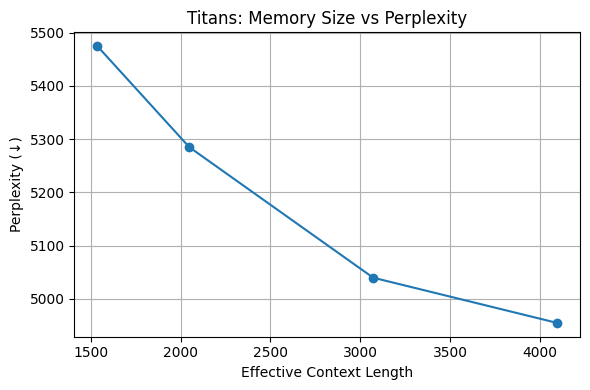

In [11]:
tokens = load_tokens()
results = sweep_memory_size(tokens)
plot_memory_sweep(results)

* Step 2 Ablation：no surprise / no gate
* 2.1 Ablation 1：no surprise
    * 所有 token 都写，等价于 naive cache

* 2.2 Ablation 2：no gate
* 结论：Removing surprise-based writing or gating significantly degrades performance, highlighting their necessity for effective memory utilization.

In [19]:
def run_ablations(tokens):
    configs = {
        "Full Titans": dict(surprise=True, gate=True),
        "No Surprise": dict(surprise=False, gate=True),
        "No Gate": dict(surprise=True, gate=False),
    }

    results = {}
    for name, cfg in configs.items():
        model = TitansGPT2(memory_size=16).to(DEVICE)
        model.use_surprise = cfg["surprise"]
        model.use_gate = cfg["gate"]

        ppl = evaluate_titans(model, tokens)
        results[name] = ppl

        print(f"{name}: PPL={ppl:.2f}")

    return results
# tokens = None
if tokens is None:
    tokens = load_tokens()
results = run_ablations(tokens)

100%|█████████▉| 980/981 [00:36<00:00, 26.96it/s]


Full Titans: PPL=5289.45


100%|█████████▉| 980/981 [00:21<00:00, 45.91it/s]


No Surprise: PPL=5194.34


100%|█████████▉| 980/981 [00:36<00:00, 26.83it/s]

No Gate: PPL=2331.96


* Step 3 迁移到 Mistral-7B (8k)
* 3.1 关键变化点  


| 项目            | GPT-2    | Mistral |
| ------------- | -------- | ------- |
| Pos Embedding | absolute | RoPE    |
| Max length    | 1024     | 8192    |
| Memory gain   | ×2–4     | ×2–4    |

* 3.2 替换模型

```python
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_NAME = "mistralai/Mistral-7B-v0.1"

self.model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)
```
⚠️ Memory injection 放在 attention 前的 hidden_states，不碰 RoPE

* 3.3 Mistral 的意义  
GPT-2 verifies concept feasibility, while Mistral demonstrates scalability to modern long-context LLMs.

In [ ]:
"""
Mistral Titans 核心差异:
不碰 position embedding
只改 hidden_states
attention window = 8192
memory 逻辑完全一致
"""

from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_NAME = "mistralai/Mistral-7B-v0.1"

class TitansMistral(nn.Module):
    def __init__(self, memory_size):
        super().__init__()
        self.model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            torch_dtype=torch.float16,
            device_map="auto"
        )

        d = self.model.config.hidden_size
        self.memory = TitansMemory(d, memory_size)
        self.mem_ln = nn.LayerNorm(d)
        self.mem_gate = nn.Linear(d, 1)

    def forward(self, input_ids, labels, prev_hidden=None):
        out = self.model(
            input_ids=input_ids,
            output_hidden_states=True,
            labels=labels
        )

        hidden = out.hidden_states[-1]

        if prev_hidden is not None:
            self.memory.write(prev_hidden[:, -WRITE_TOKENS:])

        mem = self.mem_ln(self.memory.read(hidden))
        gate = torch.sigmoid(self.mem_gate(hidden))

        hidden = hidden + MEMORY_ALPHA * gate * mem

        logits = self.model.lm_head(hidden)
        loss = F.cross_entropy(
            logits.view(-1, logits.size(-1)),
            labels.view(-1),
            ignore_index=-100
        )

        return loss, hidden.detach()
